In [1]:
# !pip install torch torchvision shap matplotlib seaborn scikit-learn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Configuración de hiperparámetros
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
PATIENCE = 5  # Paciencia para early stopping
DATASET_DIR = "../last_data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Transformaciones de datos y carga del dataset
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
from torch.utils.data import random_split
import torch
from torchvision import datasets, transforms

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ejemplo de redimensionado
    transforms.ToTensor(),  # Convertir a tensor
    # Agregar más transformaciones según tu caso
])

# Cargar el conjunto de datos original completo
full_dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)

# Dividir el conjunto de datos en entrenamiento, validación y prueba
train_size = int(0.7 * len(full_dataset))  # 70% para entrenamiento
val_size = int(0.15 * len(full_dataset))   # 15% para validación
test_size = len(full_dataset) - train_size - val_size  # Resto para prueba

train_dataset, validation_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Crear los DataLoaders para cada conjunto
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [6]:
# Definir la red neuronal
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 256 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
# Obtener el número de clases desde el conjunto completo original
num_classes = len(full_dataset.classes)

# Inicializar modelo, criterio y optimizador
model = SimpleCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()


In [8]:
# Inicializar modelo, criterio y optimizador
model = SimpleCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
# Implementar Early Stopping
best_loss = np.inf
patience = PATIENCE
trigger_times = 0


In [10]:
# Historial para gráficos
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [11]:
# Entrenamiento y validación
for epoch in range(EPOCHS):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, val_predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(validation_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Early Stopping Check
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Guardar el mejor modelo
    else:
        trigger_times += 1
        print(f"Early stopping trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping!")
            break

Epoch 1/20, Train Loss: 1.5200, Train Accuracy: 30.05%, Val Loss: 1.5055, Val Accuracy: 32.04%
Epoch 2/20, Train Loss: 1.2771, Train Accuracy: 48.92%, Val Loss: 1.1661, Val Accuracy: 54.95%
Epoch 3/20, Train Loss: 1.0798, Train Accuracy: 58.84%, Val Loss: 0.9278, Val Accuracy: 64.40%
Epoch 4/20, Train Loss: 0.9796, Train Accuracy: 64.18%, Val Loss: 0.9587, Val Accuracy: 64.24%
Early stopping trigger times: 1/5
Epoch 5/20, Train Loss: 0.9066, Train Accuracy: 66.67%, Val Loss: 0.8132, Val Accuracy: 70.43%
Epoch 6/20, Train Loss: 0.8154, Train Accuracy: 70.85%, Val Loss: 0.8014, Val Accuracy: 68.73%
Epoch 7/20, Train Loss: 0.8087, Train Accuracy: 71.58%, Val Loss: 0.7115, Val Accuracy: 75.08%
Epoch 8/20, Train Loss: 0.7466, Train Accuracy: 72.57%, Val Loss: 0.8626, Val Accuracy: 71.05%
Early stopping trigger times: 1/5
Epoch 9/20, Train Loss: 0.6828, Train Accuracy: 75.59%, Val Loss: 0.6518, Val Accuracy: 77.09%
Epoch 10/20, Train Loss: 0.6110, Train Accuracy: 78.28%, Val Loss: 0.6906, Va

In [12]:
# Cargar el mejor modelo (si se activó el early stopping)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

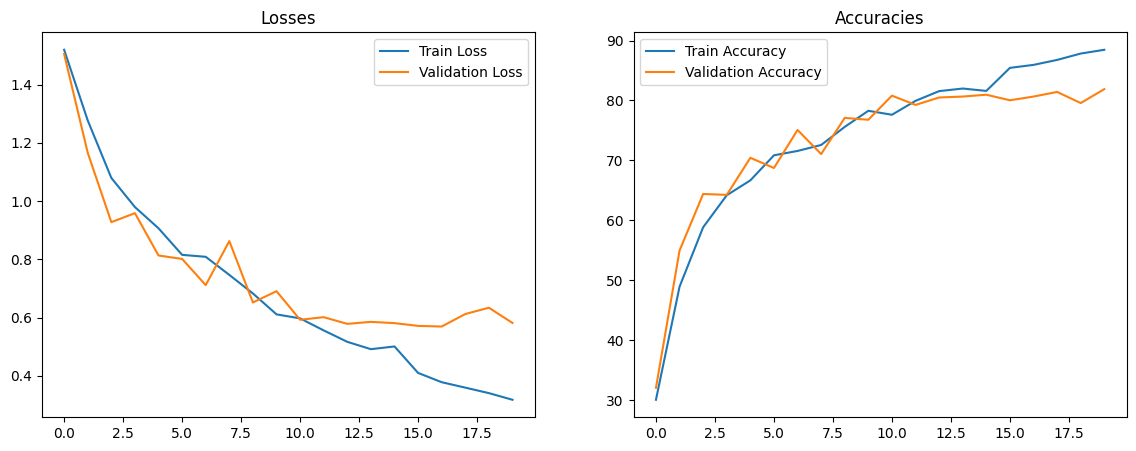

In [13]:
# Graficar las pérdidas y las precisiones
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracies')

plt.show()

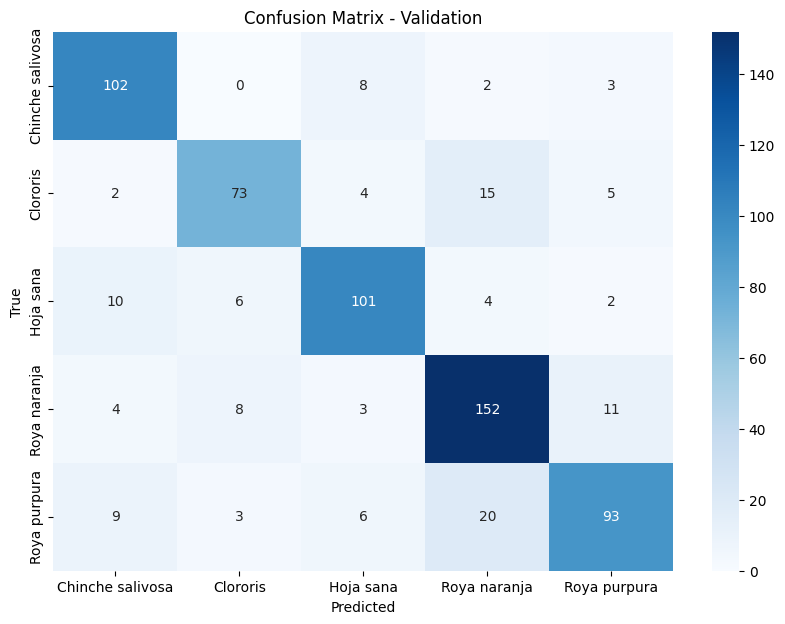

Classification Report - Validation:
                  precision    recall  f1-score   support

Chinche salivosa       0.80      0.89      0.84       115
        Clororis       0.81      0.74      0.77        99
       Hoja sana       0.83      0.82      0.82       123
    Roya naranja       0.79      0.85      0.82       178
    Roya purpura       0.82      0.71      0.76       131

        accuracy                           0.81       646
       macro avg       0.81      0.80      0.80       646
    weighted avg       0.81      0.81      0.81       646



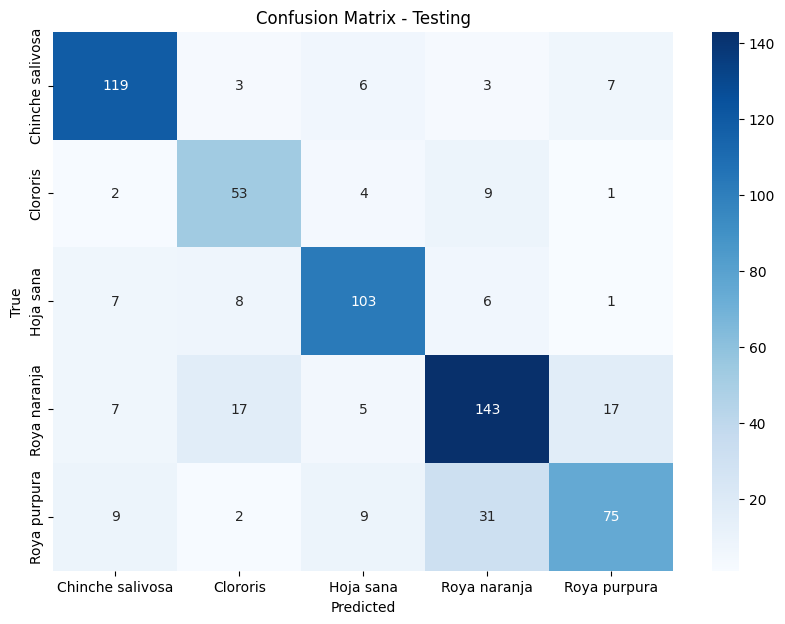

Classification Report - Testing:
                  precision    recall  f1-score   support

Chinche salivosa       0.83      0.86      0.84       138
        Clororis       0.64      0.77      0.70        69
       Hoja sana       0.81      0.82      0.82       125
    Roya naranja       0.74      0.76      0.75       189
    Roya purpura       0.74      0.60      0.66       126

        accuracy                           0.76       647
       macro avg       0.75      0.76      0.75       647
    weighted avg       0.76      0.76      0.76       647



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Evaluar en el conjunto de validación
def evaluate_model(loader, model, phase):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, full_dataset.classes, f'Confusion Matrix - {phase}')

    # Generar el reporte de clasificación
    report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)
    print(f'Classification Report - {phase}:\n{report}')

# Evaluar en el conjunto de validación
evaluate_model(validation_loader, model, "Validation")

# Evaluar en el conjunto de prueba (testing)
evaluate_model(test_loader, model, "Testing")
